# German Credit Dataset - Анализ данных

Описание признаков
Age - возраст клиента.
Sex - пол клиента.
Job - тип работы клиента.
Housing - тип жилья.
Saving accounts - наличие сберегательных счетов.
Checking account - наличие текущих счетов.
Credit amount - сумма кредита.
Duration - продолжительность кредита.
Purpose - цель кредита.
Risk - риск (бинарный признак: хорошая или плохая кредитная история).

In [75]:
#Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest as ztest

#Загрузка датасета
df = pd.read_csv('Downloads/german_credit_risk.csv')

#Отображение первых пяти строк фрейма данных, чтобы просмотреть данные
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# Разведочный анализ данных, EDA

In [3]:
#Сколько в датасете строк и столбцов?
df.shape

(1000, 11)

In [4]:
#тип данных каждого признака
print(df.dtypes)

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object


In [5]:
#пропуски в данных
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
#Ненужная колонка
df = df.drop(['Unnamed: 0'], axis=1)
df.shape

(1000, 10)

In [7]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR
    return df[(df[column] >= low) & (df[column] <= up)]

df_copy = df.copy()
for column in ['Age', 'Credit amount', 'Duration']:
    df_copy = remove_outliers(df_copy, column)

remove = len(df) - len(df_copy)
print(f'Количество удаленных строк: {remove}')

df_copy

Количество удаленных строк: 139


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
2,49,male,1,own,little,NaN,2096,12,education,good
4,53,male,2,free,little,little,4870,24,car,bad
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
...,...,...,...,...,...,...,...,...,...,...
993,30,male,3,own,little,little,3959,36,furniture/equipment,good
994,50,male,2,own,NaN,NaN,2390,12,car,good
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good


In [13]:
df.describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000,1000.000000,1000,817,606,1000.000000,1000.000000,1000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8,2
top,NaN,male,NaN,own,little,little,NaN,NaN,car,good
freq,NaN,690,NaN,713,603,274,NaN,NaN,337,700
mean,35.546000,NaN,1.904000,NaN,NaN,NaN,3271.258000,20.903000,NaN,NaN
std,11.375469,NaN,0.653614,NaN,NaN,NaN,2822.736876,12.058814,NaN,NaN
min,19.000000,NaN,0.000000,NaN,NaN,NaN,250.000000,4.000000,NaN,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,NaN,1365.500000,12.000000,NaN,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,NaN,2319.500000,18.000000,NaN,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,NaN,3972.250000,24.000000,NaN,NaN


In [15]:
df['Age'].quantile(0.75)-df['Age'].quantile(0.25)

15.0

In [18]:
df["Age"].var(ddof = 0)

129.27188399999974

In [20]:
df["Age"].var()

129.40128528528504

In [22]:
df['Age'].std(ddof=0)

11.36977941738536

In [23]:
df["Age"].std()

11.375468574317502

# Визуализация

C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


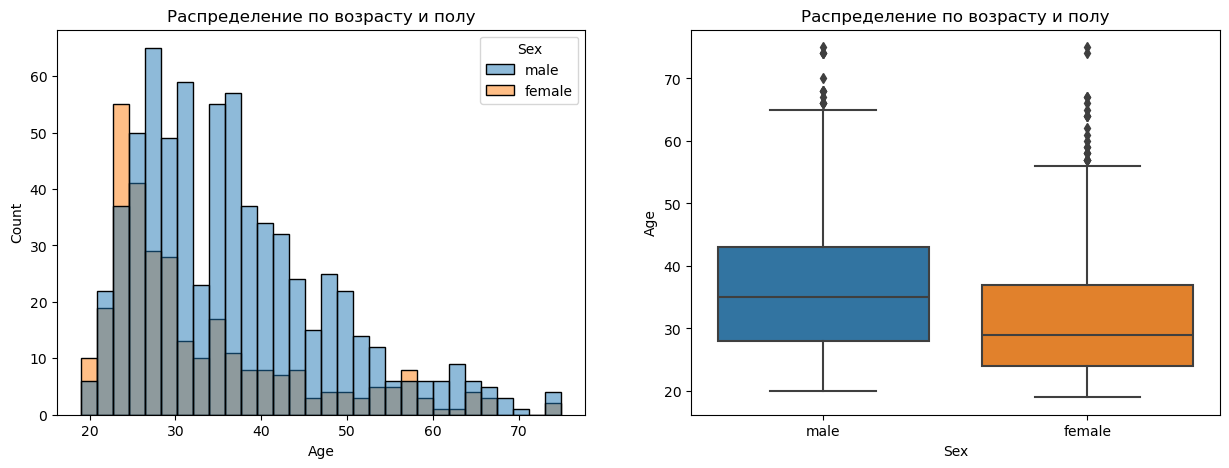

In [117]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Sex", ax=ax[0]).set_title("Распределение по возрасту и полу");
sns.boxplot(data=df, x="Sex", y="Age", ax=ax[1]).set_title("Распределение по возрасту и полу");

C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


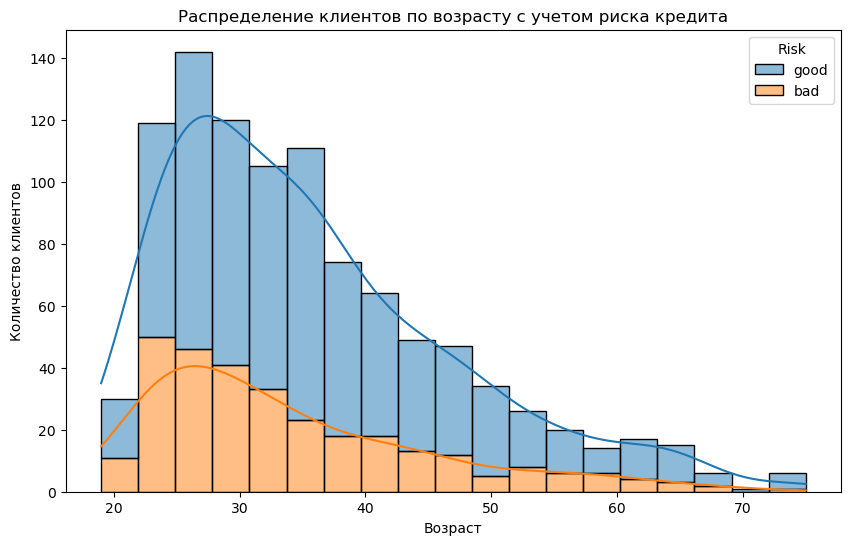

In [28]:
# График распределения клиентов по возрасту с учетом риска
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Age', hue='Risk', multiple='stack', kde=True)
plt.title('Распределение клиентов по возрасту с учетом риска кредита')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

C:\Users\siegf\AppData\Local\Temp\ipykernel_16820\669742901.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


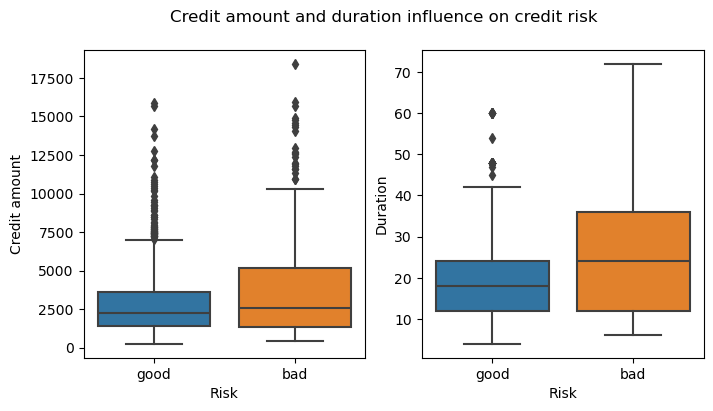

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=df, x="Risk", y="Credit amount", ax=ax0)
sns.boxplot(data=df, x="Risk", y="Duration", ax=ax1)
fig.suptitle("Credit amount and duration influence on credit risk")
fig.show()

C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

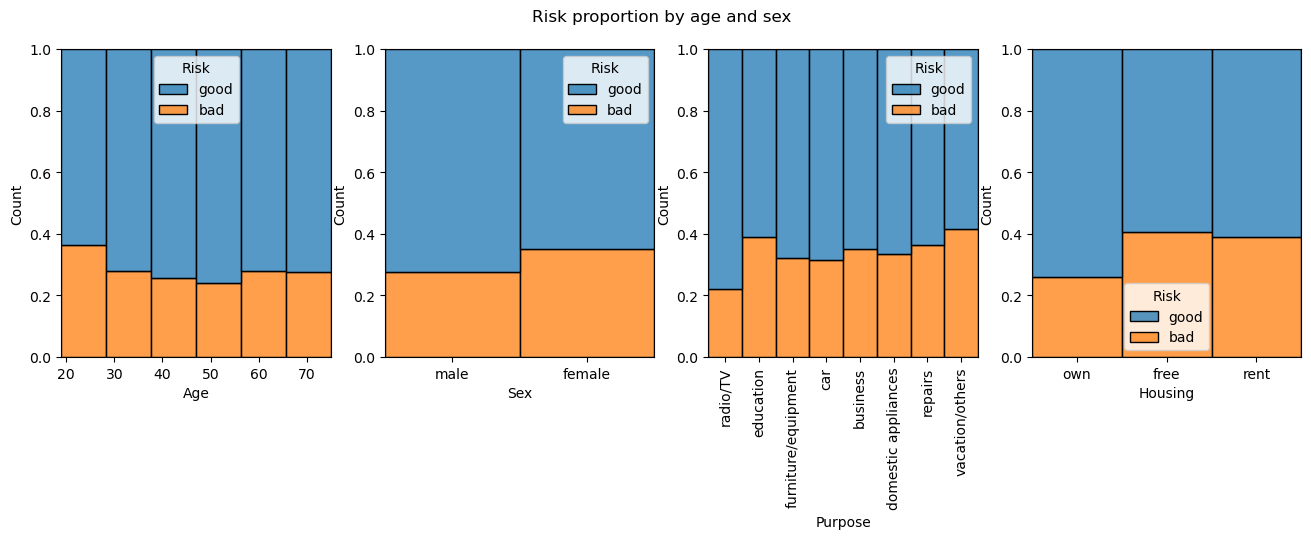

In [31]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4))
sns.histplot(data=df, x="Age", hue="Risk", multiple="fill", bins=6, ax=ax0)
sns.histplot(data=df, x="Sex", hue="Risk", multiple="fill", ax=ax1)
sns.histplot(data=df, x="Purpose", hue="Risk", multiple="fill", ax=ax2)
sns.histplot(data=df, x="Housing", hue="Risk", multiple="fill", ax=ax3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation= 90)
fig.suptitle("Risk proportion by age and sex")
plt.show()

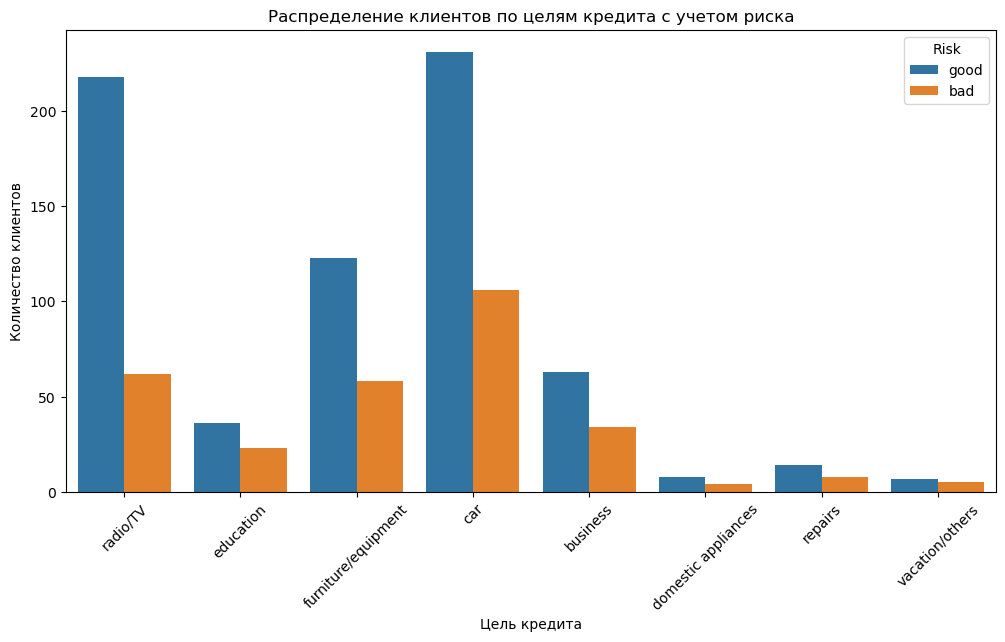

In [34]:
#График распределения клиентов по целям кредита
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Purpose', hue='Risk')
plt.title('Распределение клиентов по целям кредита с учетом риска')
plt.xlabel('Цель кредита')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.show()

# Корреляция

                    Age  Credit amount  Duration
Age            1.000000       0.032716 -0.036136
Credit amount  0.032716       1.000000  0.624984
Duration      -0.036136       0.624984  1.000000


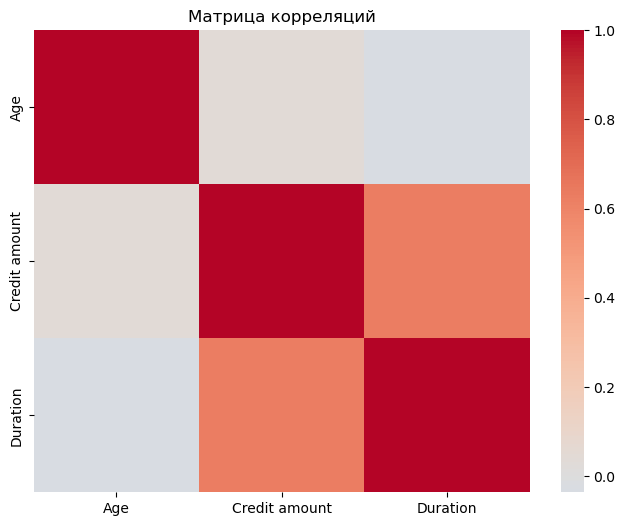

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

#Построение матрицы корреляций
correlation_matrix = df[['Age', 'Credit amount', 'Duration']].corr()

#Вывод матрицы корреляций
print(correlation_matrix)

#Отображение матрицы корреляций
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\siegf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


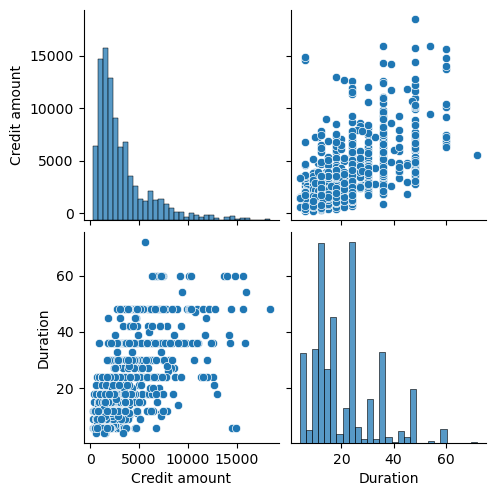

In [40]:
#линейная корреляция
sns.pairplot(data = df[['Credit amount','Duration']]);

# Тестирование гипотез

In [47]:
for col in ["Sex", "Purpose", "Risk"]:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,NaN,little,1169,6,5,1
1,22,0,2,own,little,moderate,5951,48,5,0
2,49,1,1,own,little,NaN,2096,12,3,1
3,45,1,2,free,little,little,7882,42,4,1
4,53,1,2,free,little,little,4870,24,1,0


In [49]:
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

df["Saving accounts"] = df["Saving accounts"].apply(SC_LabelEncoder)
df["Checking account"] = df["Checking account"].apply(SC_LabelEncoder)

def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2

df["Housing"] = df["Housing"].apply(H_LabelEncoder)

df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,2,0,1,1169,6,5,1
1,22,0,2,2,1,2,5951,48,5,0
2,49,1,1,2,1,0,2096,12,3,1
3,45,1,2,0,1,1,7882,42,4,1
4,53,1,2,0,1,1,4870,24,1,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,2,1,0,1736,12,4,1
996,40,1,3,2,1,1,3857,30,1,1
997,38,1,2,2,1,0,804,12,5,1
998,23,1,2,0,1,1,1845,45,5,0


In [51]:
ff = df.groupby('Sex')['Risk'].value_counts().unstack()
ff

Risk,0,1
Sex,,
0,109,201
1,191,499


In [53]:
result = stats.chi2_contingency(ff, correction=False)
result

Chi2ContingencyResult(statistic=5.699147354126317, pvalue=0.016973156439130086, dof=1, expected_freq=array([[ 93., 217.],
       [207., 483.]]))

In [55]:
result.pvalue>0.05

False

In [57]:
f = df.groupby('Purpose')['Risk'].value_counts().unstack()
f

Risk,0,1
Purpose,,
0,34,63
1,106,231
2,4,8
3,23,36
4,58,123
5,62,218
6,8,14
7,5,7


In [59]:
res = stats.chi2_contingency(f, correction=False)
res

Chi2ContingencyResult(statistic=13.642086296939734, pvalue=0.05792591119293633, dof=7, expected_freq=array([[ 29.1,  67.9],
       [101.1, 235.9],
       [  3.6,   8.4],
       [ 17.7,  41.3],
       [ 54.3, 126.7],
       [ 84. , 196. ],
       [  6.6,  15.4],
       [  3.6,   8.4]]))

In [61]:
res.pvalue>0.05

True

In [81]:
from scipy import stats

# Выборки
good_risk_ages = df[df['Risk'] == 'good']['Age']
bad_risk_ages = df[df['Risk'] == 'bad']['Age']

# Проведение t-теста для независимых выборок
t_stat, p_value = stats.ttest_ind(good_risk_ages, bad_risk_ages)
t_stat, p_value
# Вывод результатов
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_value}")

# Уровень значимости
alpha = 0.05

# Проверка гипотезы
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Средние значения возраста клиентов с хорошим и плохим кредитным риском различны.")
else:
    print("Не отвергаем нулевую гипотезу: Нет статистически значимого различия между средними значениями возраста клиентов с хорошим и плохим кредитным риском.")


t-статистика: 2.890846677564194
p-значение: 0.003925339398276282
Отвергаем нулевую гипотезу: Средние значения возраста клиентов с хорошим и плохим кредитным риском различны.


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Выбор признаков и целевой переменной
features = ['Age', 'Credit amount', 'Duration']  # Можно добавить больше признаков
target = 'Risk'  # Целевая переменная

# Преобразование целевой переменной в числовую (1 - good, 0 - bad)
df[target] = df[target].apply(lambda x: 1 if x == 'good' else 0)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Вывод метрик
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.72
ROC AUC: 0.5634365634365635

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.10      0.18        91
           1       0.72      0.99      0.83       209

    accuracy                           0.72       300
   macro avg       0.77      0.54      0.50       300
weighted avg       0.75      0.72      0.63       300


Confusion Matrix:
[[  9  82]
 [  2 207]]


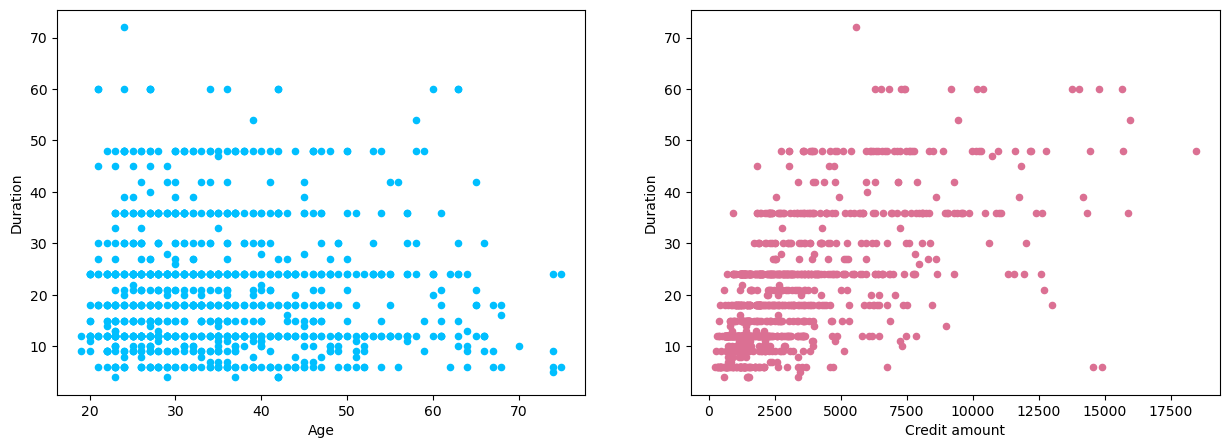

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax1 = df.plot(kind='scatter', x='Age', y='Duration', ax=axs[0], c='deepskyblue')
ax2 = df.plot(kind='scatter', x='Credit amount', y='Duration', ax=axs[1], c='palevioletred')
plt.show()